In [1]:
import gc
import os 
import torch
import pickle
import pandas as pd

import matplotlib.pyplot as plt

from collections import OrderedDict
from datetime import datetime

import utils.print as print_f

import numpy as np
from pycocotools.cocoeval import Params
from utils.coco_utils import get_coco_api_from_dataset
from utils.coco_eval import external_summarize, get_eval_params_dict

from utils.transforms import get_transform
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.save import  get_train_data
from utils.plot import transparent_cmap, plot_result, plot_loss, get_legend_elements, plot_evaluator
from data.dataset import ReflacxDataset, collate_fn
from models.rcnn import get_model_instance_segmentation, get_multimodal_model_instance_segmentation

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
# Clean up memory.
gc.collect()
torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [3]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

In [4]:
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device}]")

This notebook will running on device: [cuda]


In [5]:
use_clinical = True

In [6]:
disease_cmap = {
    "transparent": {
        "Enlarged cardiac silhouette": transparent_cmap(plt.cm.autumn),
        "Atelectasis": transparent_cmap(plt.cm.Reds),
        "Pleural abnormality": transparent_cmap(plt.cm.Oranges),
        "Consolidation": transparent_cmap(plt.cm.Greens),
        "Pulmonary edema": transparent_cmap(plt.cm.Blues),
    },
    "solid": {
        "Enlarged cardiac silhouette": "yellow",
        "Atelectasis": "red",
        "Pleural abnormality": "orange",
        "Consolidation": "lightgreen",
        "Pulmonary edema": "dodgerblue",
    },
}

legend_elements = get_legend_elements(disease_cmap["solid"])

In [7]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": use_clinical,
    "using_full_reflacx": False,
    "bbox_to_mask": True,
    "labels_cols": labels_cols,
}

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "using_full_reflacx": False,},
    transforms=get_transform(train=False),
)

train_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="train", transforms=get_transform(train=True),
)

val_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="val", transforms=get_transform(train=False),
)

test_dataset = ReflacxDataset(
    **dataset_params_dict, split_str="test", transforms=get_transform(train=False),
)

batch_size = 4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,
)


In [8]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.5608, 0.5608],
          [0.0000, 0.0000, 0.0000,  ..., 0.5647, 0.5647, 0.5569],
          [0.0000, 0.0000, 0.0000,  ..., 0.5608, 0.5569, 0.5490],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7686, 0.7686],
          [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7647, 0.7608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.7569, 0.7529]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.5608, 0.5608],
          [0.0000, 0.0000, 0.0000,  ..., 0.5647, 0.5647, 0.5569],
          [0.0000, 0.0000, 0.0000,  ..., 0.5608, 0.5569, 0.5490],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.7686, 0.7686],
          [1.0000, 1.0000, 1.0000,  ..., 0.7608, 0.7647, 0.7608],
          [1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.7569, 0.7529]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.5569, 0.5608, 0.5608],
          [0.0000, 0.0000, 0.0000,  ..., 0.5647, 0.5647, 0.5569],
          [0.0000, 0.0000, 0.0000,  ...,

In [9]:
# model = get_model_instance_segmentation(len(train_dataset.labels_cols) +1)
model = get_multimodal_model_instance_segmentation(
    len(train_dataset.labels_cols) +1,
    use_clinical=use_clinical,
)
    
model.to(device)

{'rpn_nms_thresh': 0.3, 'box_detections_per_img': 6, 'box_nms_thresh': 0.2, 'rpn_score_thresh': 0.0, 'box_score_thresh': 0.05}
c1
None


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu

In [10]:
print(f"Model size: {sum([param.nelement()  for param in model.parameters()]):,}")

Model size: 45,986,017


In [11]:
params = [p for p in model.parameters() if p.requires_grad]
lr_scheduler = None

# construct an optimizer

# optimizer = torch.optim.Adam(params, lr=0.05 ,weight_decay=0.0005)
# lr_scheduler = None

## Original Setting (Kinda work)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

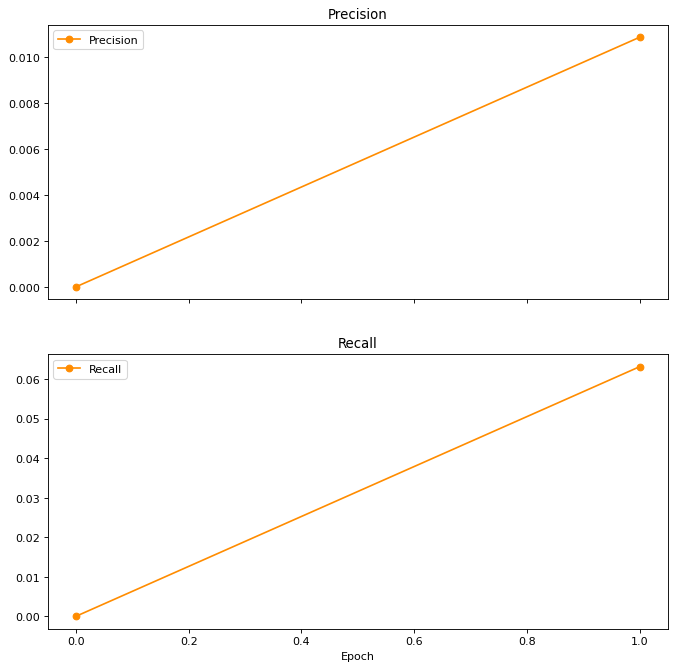

====================| Training Done, start testing! | Training time: [304] seconds, Avg time / Epoch: [152.0] seconds====================
creating index...
index created!
Test:  [ 0/26]  eta: 0:00:37  model_time: 0.3571 (0.3571)  evaluator_time: 0.4261 (0.4261)  time: 1.4413  data: 0.5891  max mem: 2300
Test:  [25/26]  eta: 0:00:01  model_time: 0.1870 (0.2100)  evaluator_time: 0.3141 (0.3317)  time: 1.2970  data: 0.6809  max mem: 2300
Test: Total time: 0:00:34 (1.3159 s / it)
Averaged stats: model_time: 0.1870 (0.2100)  evaluator_time: 0.3141 (0.3317)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 A

In [12]:
num_epochs = 2

train_logers = []
val_evaluators = []

start_t = datetime.now()

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    model.train()

    train_loger = xami_train_one_epoch(
        model,
        optimizer,
        train_dataloader,
        device,
        epoch,
        print_freq=10,
    )

    train_logers.append(train_loger)
    plot_loss(train_logers)

    model.eval()

    # update the learning rate
    if not lr_scheduler is None:
        lr_scheduler.step()
    # evaluate on the test dataset
    val_evaluator = xami_evaluate(model, val_dataloader, device=device)
    val_evaluators.append(val_evaluator)

    plot_evaluator(
        val_evaluators,
        areaRng='all',
        iouThr=.5,
        maxDets=10,
    )

    for i in [250, 99, 199]:
        plot_result(
            model=model,
            dataset=detect_eval_dataset,
            device=device,
            idx=i,
            legend_elements=legend_elements,
            disease_cmap=disease_cmap,
            seg=False,
            seg_thres=0.5,
        )


end_t = datetime.now()

sec_took = (end_t - start_t).seconds

print_f.print_title(
    f"| Training Done, start testing! | Training time: [{sec_took}] seconds, Avg time / Epoch: [{sec_took/num_epochs}] seconds"
)

test_evaluator = xami_evaluate(model, test_dataloader, device=device)


In [13]:
# chekcing if a part of the model is being trained.
# for sector in [model.clinical_convs, model.fuse_convs]:
#     print(
#         sum(
#             [
#                 sum([p.grad.abs().sum() for p in model.clinical_convs[k].parameters()])
#                 for k in sector.keys()
#             ]
#         )
#     )

In [14]:
test_evaluator.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.034
IoU metric: segm
 A

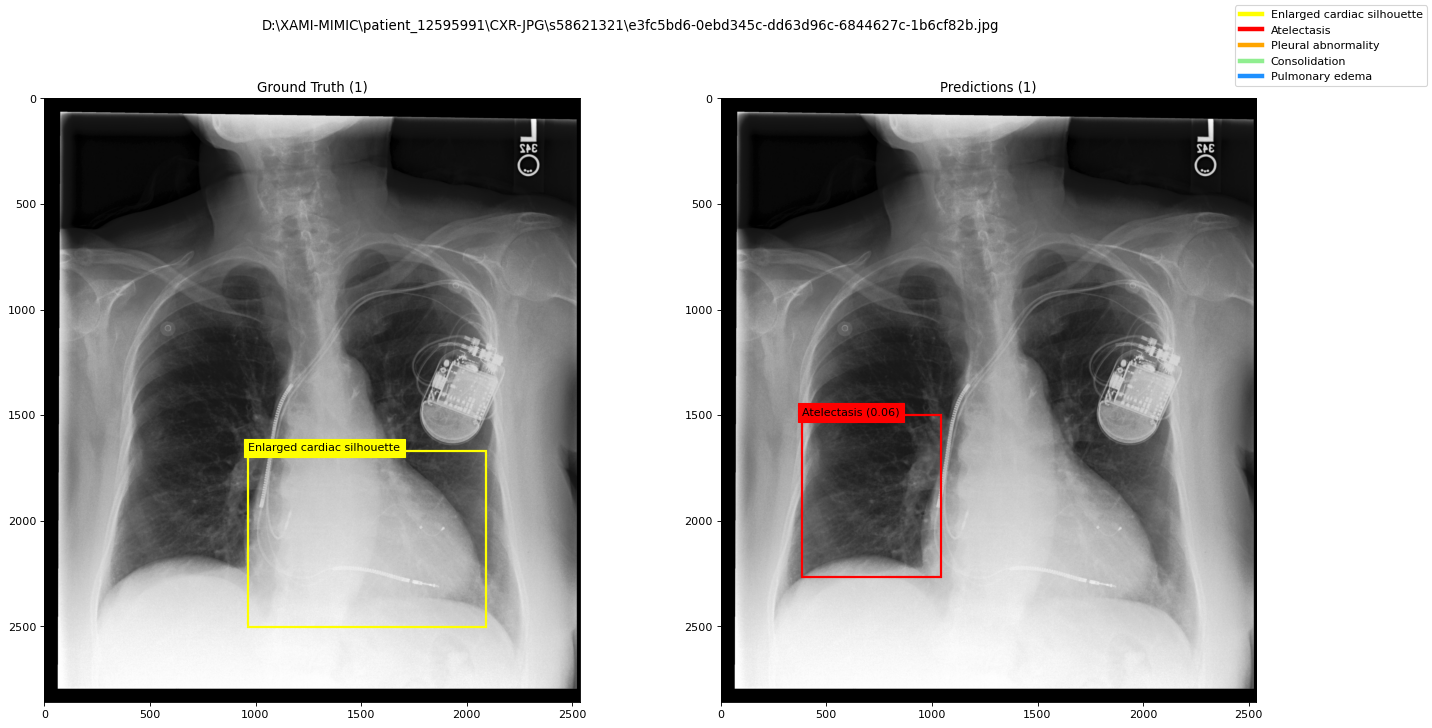

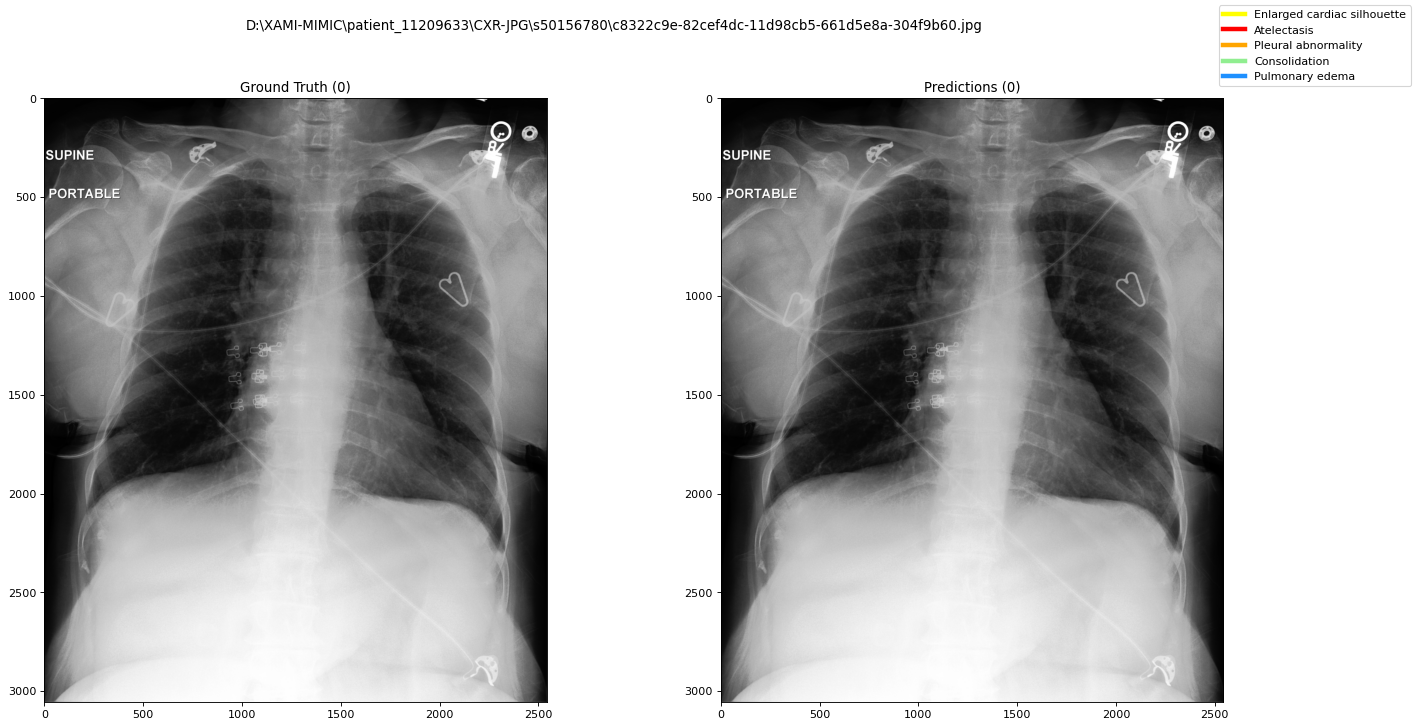

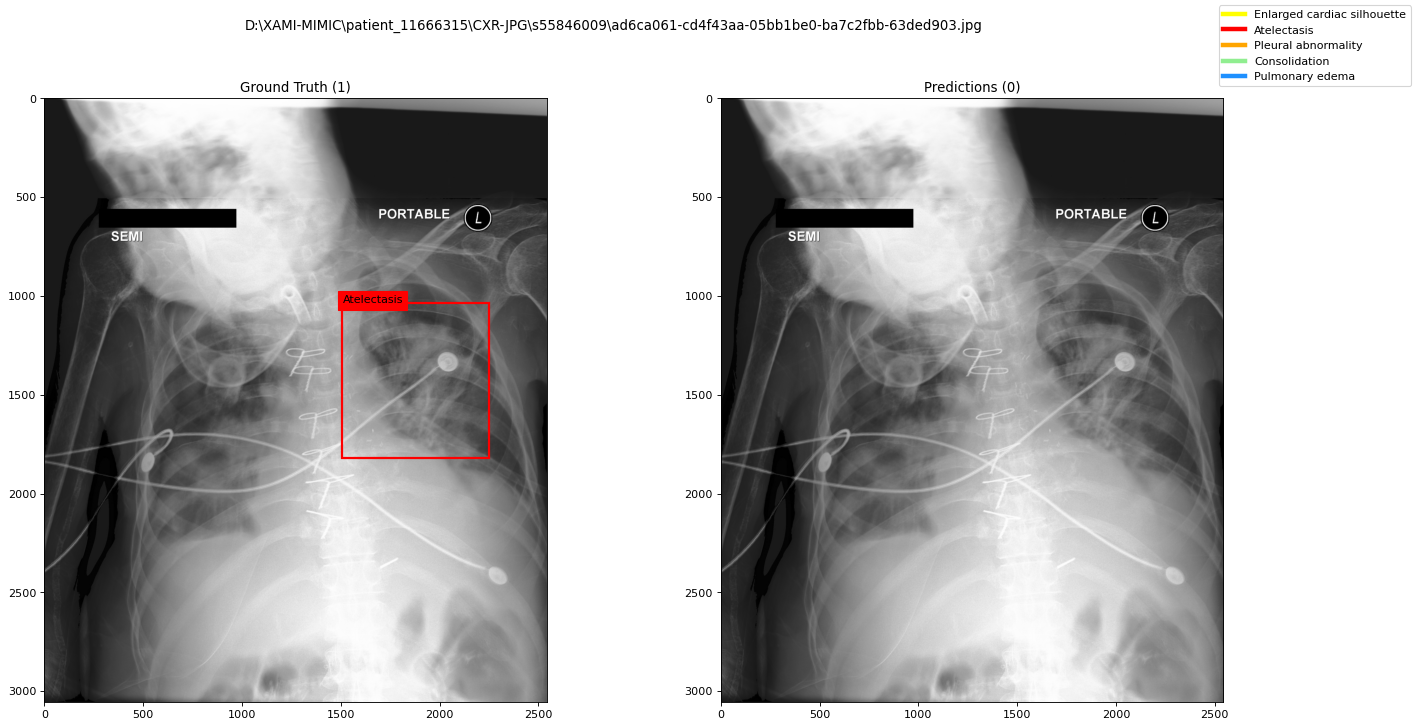

In [15]:
for i in [250, 99, 199]:
    plot_result(
        model=model,
        dataset=detect_eval_dataset,
        device=device,
        idx= i,
        legend_elements= legend_elements,
        disease_cmap =disease_cmap,
        seg=False,
        seg_thres=0.5,
    )

In [16]:
eval_params_dict = get_eval_params_dict(detect_eval_dataset)

In [ ]:
params_test_evaluator = xami_evaluate(model, test_dataloader, device=device, params_dict=eval_params_dict)
params_test_evaluator.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).


AxisError: axis 2 is out of bounds for array of dimension 2

In [ ]:
_ = external_summarize(params_test_evaluator.coco_eval['bbox'], ap=1, iouThr=.5, areaRng='all', maxDets=6)
_ = external_summarize(params_test_evaluator.coco_eval['bbox'], ap=0, iouThr=.5, areaRng='all', maxDets=6)

In [ ]:
training_record = OrderedDict({
    "train_data": [ get_train_data(loger) for loger in train_logers],
    "val_evaluators" : val_evaluators,
    "test_evaluator": test_evaluator,
})

In [ ]:
clinial_cond = "With" if train_dataset.with_clinical else "Without"
current_time_string = datetime.now().strftime("%m-%d-%Y %H-%M-%S")
final_model_path =  f"epoch{epoch}_{clinial_cond}Clincal_{current_time_string}".replace(":", "_").replace(".", "_")

In [ ]:
torch.save(model.state_dict(), os.path.join(
    os.path.join('trained_models', final_model_path)
))

print(f"Model has been saved: {final_model_path}")

Model has been saved: epoch99_WithoutClincal_03-12-2022 07-56-08


In [ ]:
# epoch99_WithoutClincal_03-11-2022 09-05-17  (custom)
# epoch99_WithClincal_03-11-2022 17-34-14 (custom)
# epoch99_WithoutClincal_03-12-2022 07-56-08 (original)

In [ ]:
with open(
    os.path.join("training_records", f"{final_model_path}.pkl"), "wb",
) as training_record_f:
    pickle.dump(training_record, training_record_f)